In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
data = pd.read_csv('london_weather.csv')
data = data.sort_values(by='date')
print(data.head())

       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  


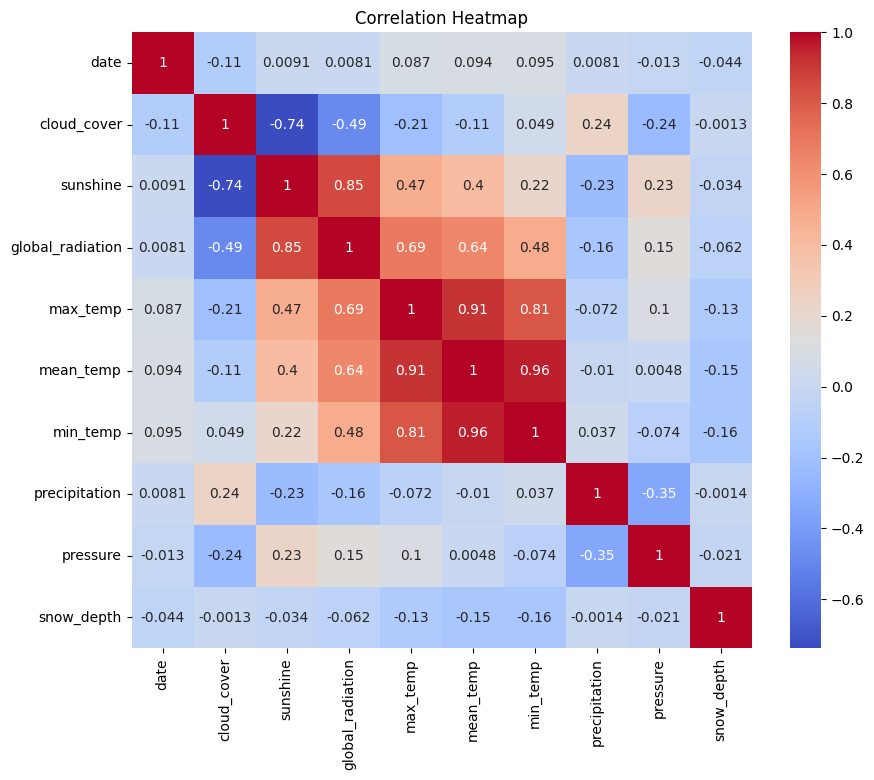

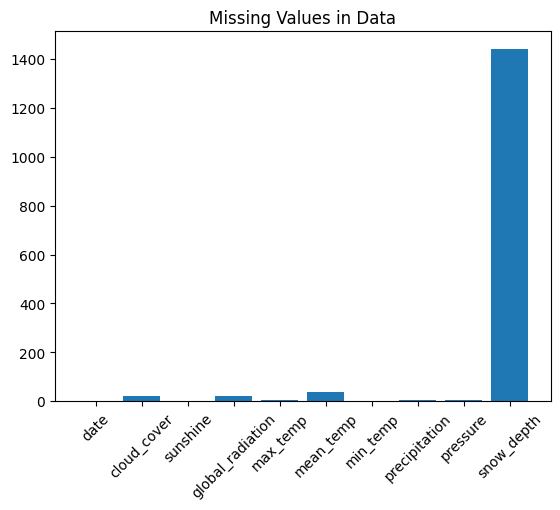

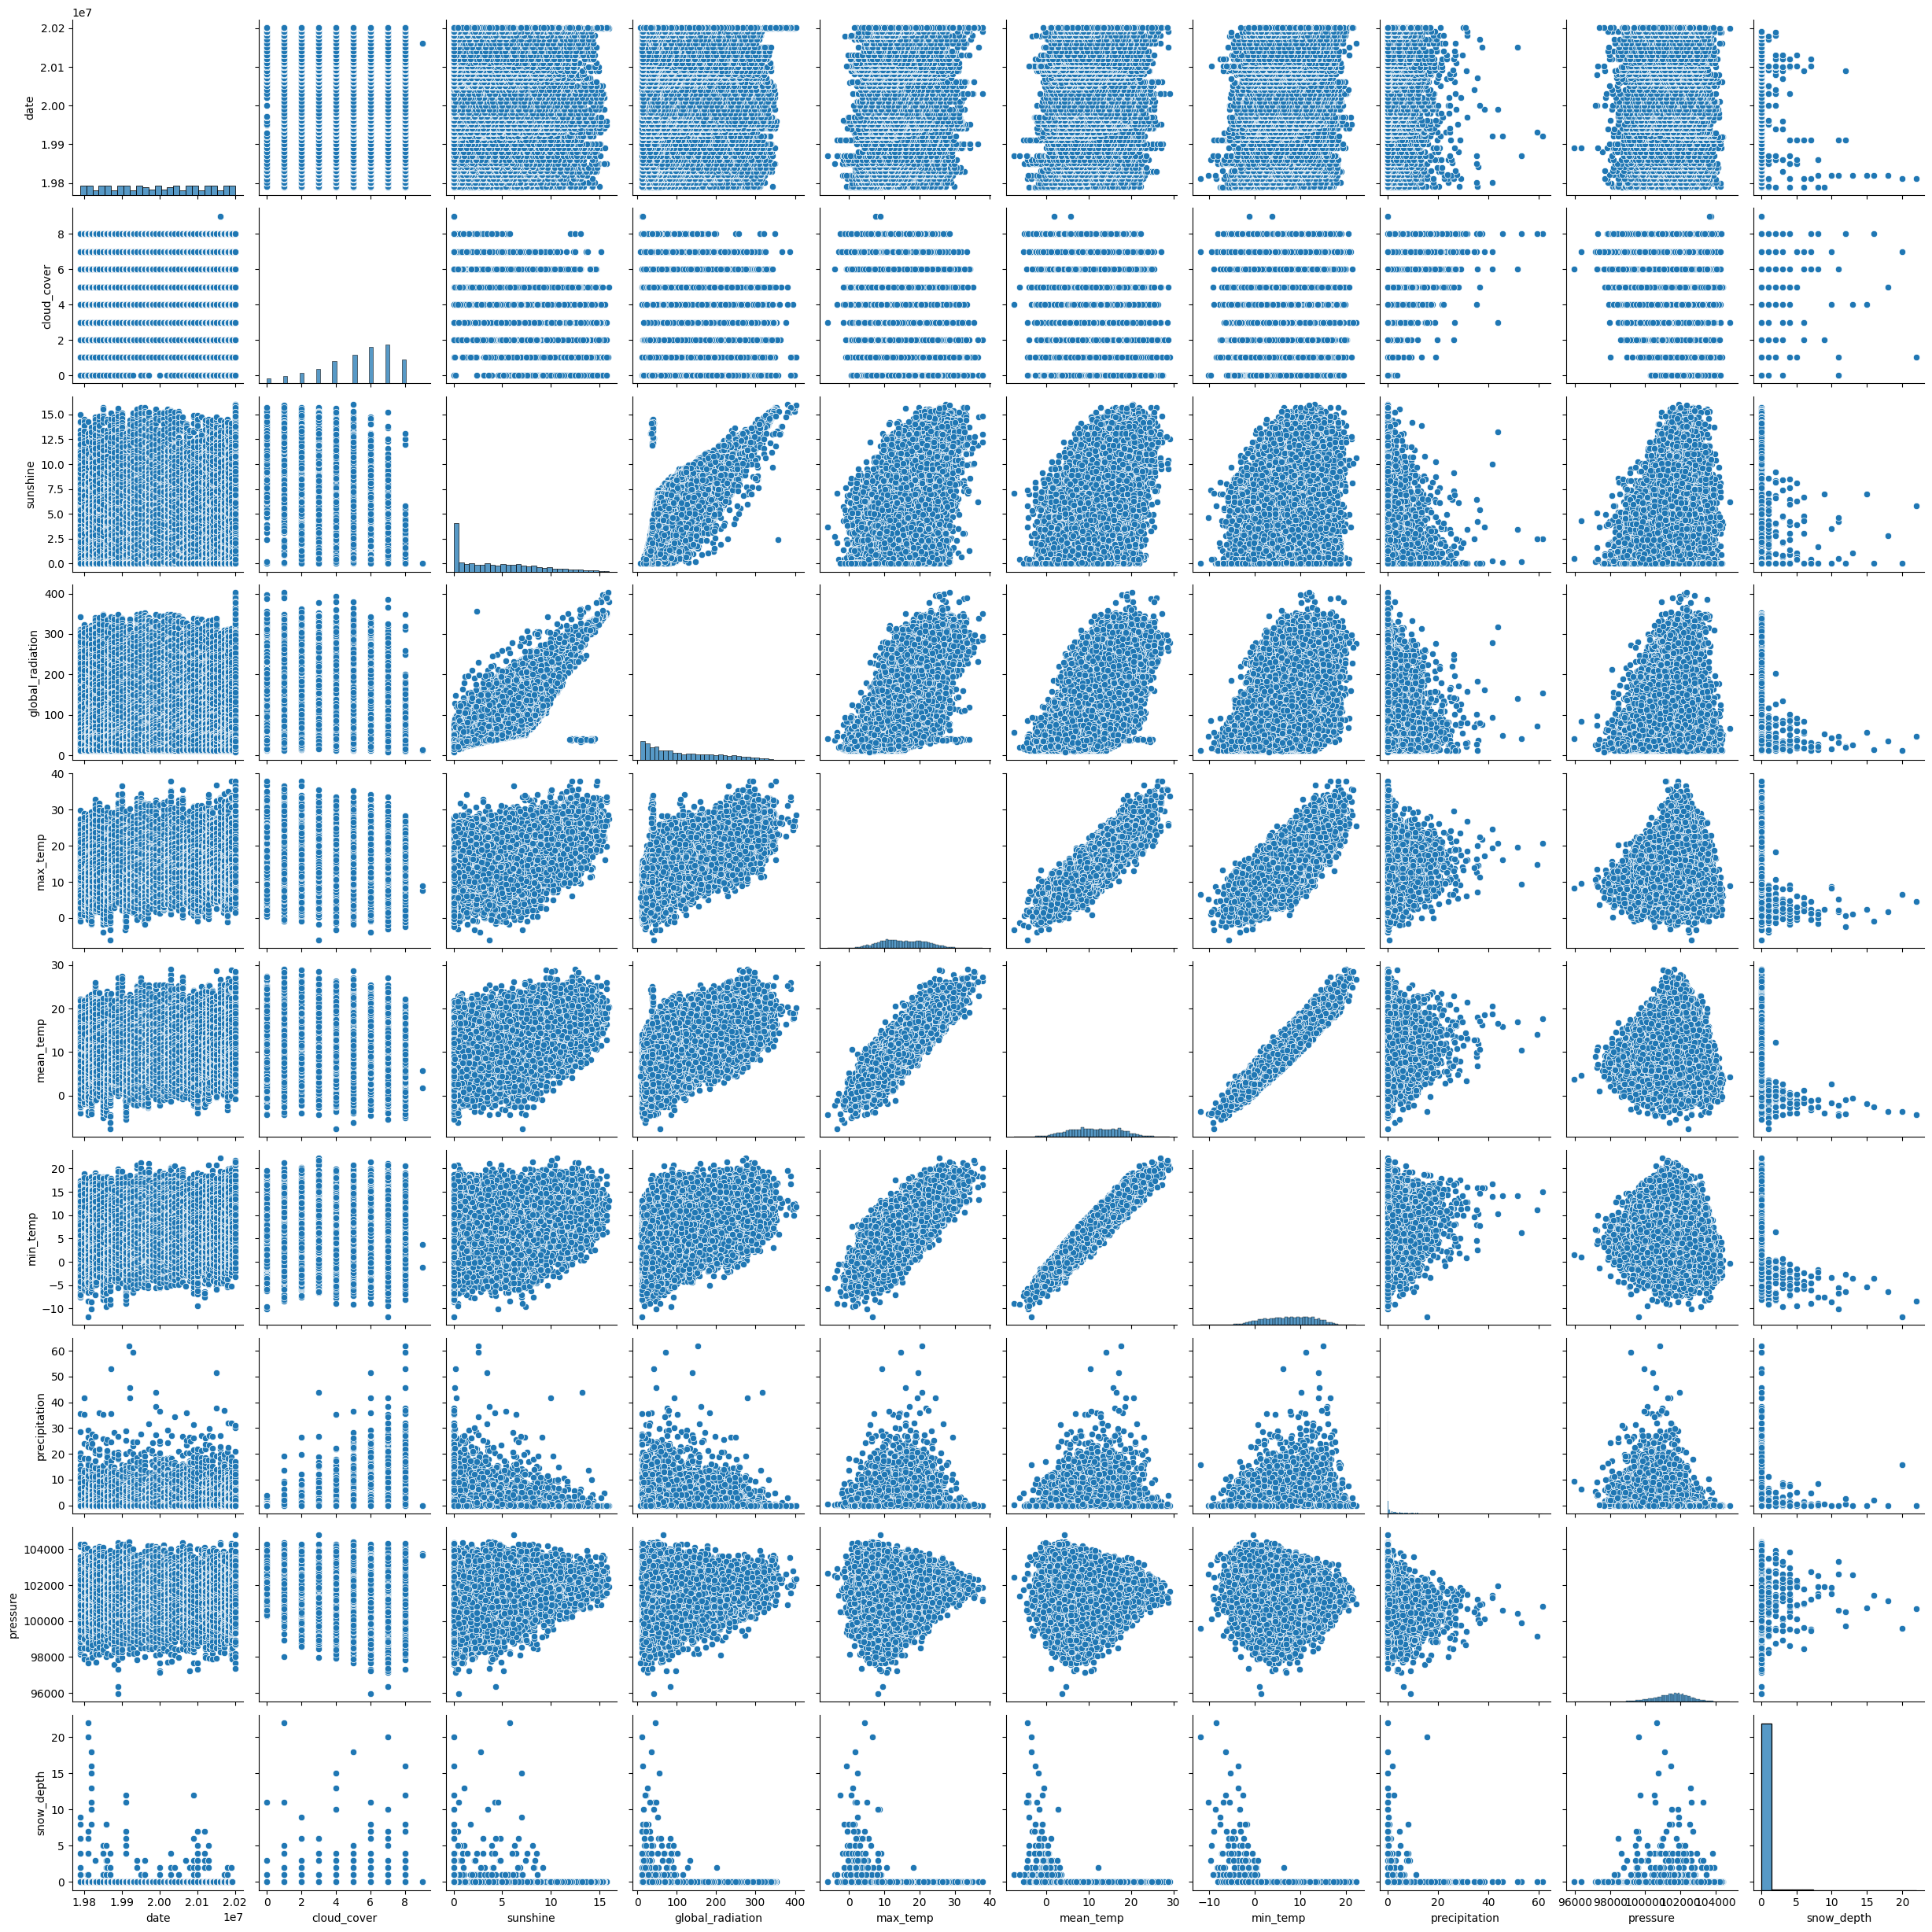

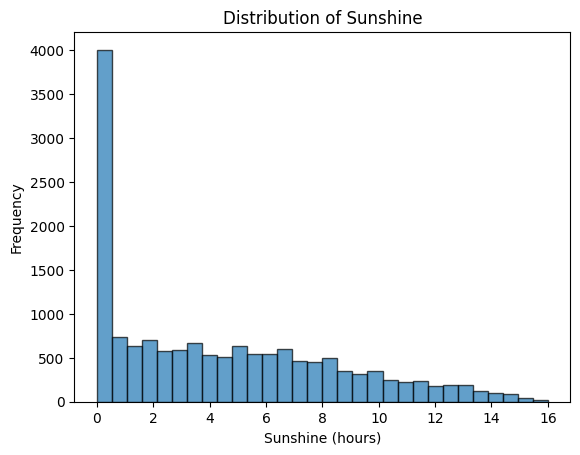

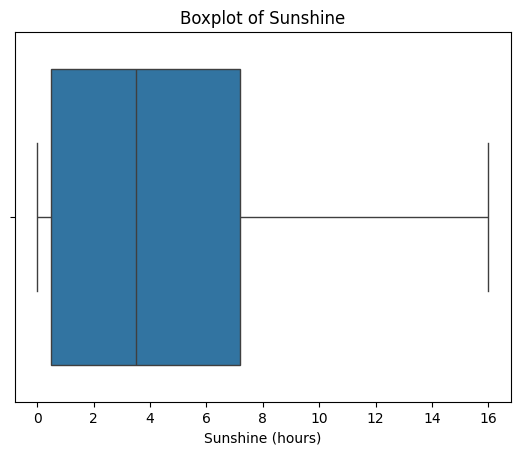

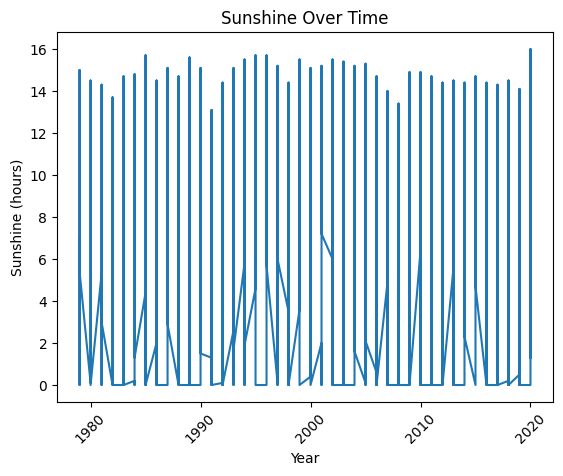

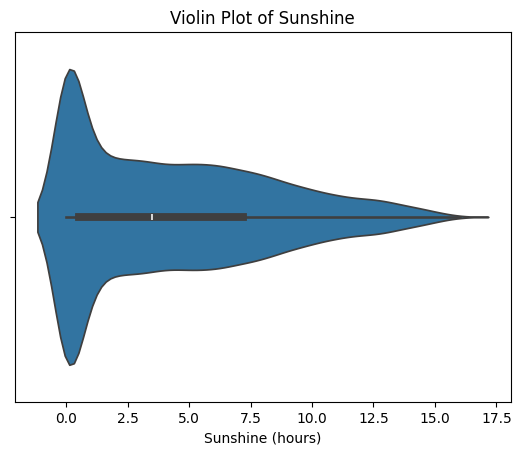

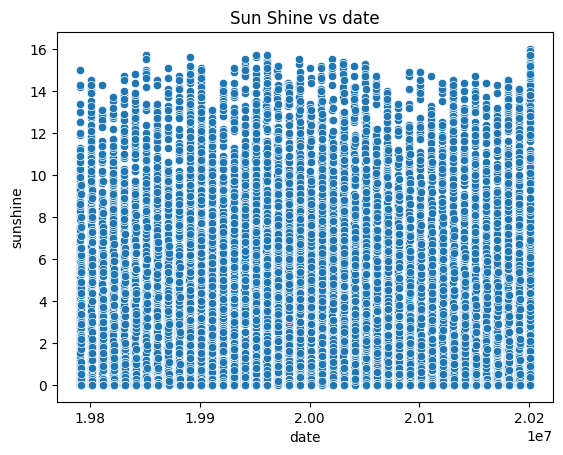

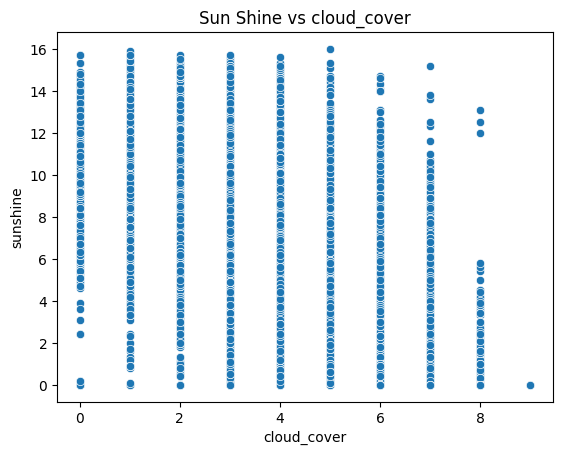

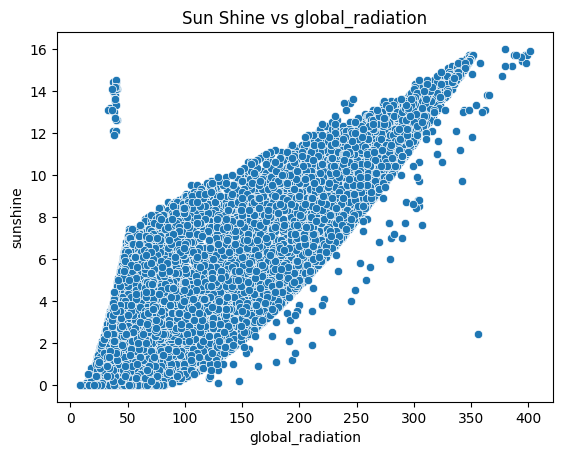

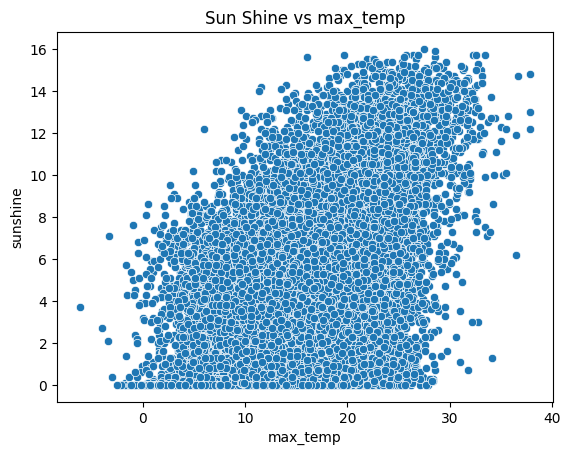

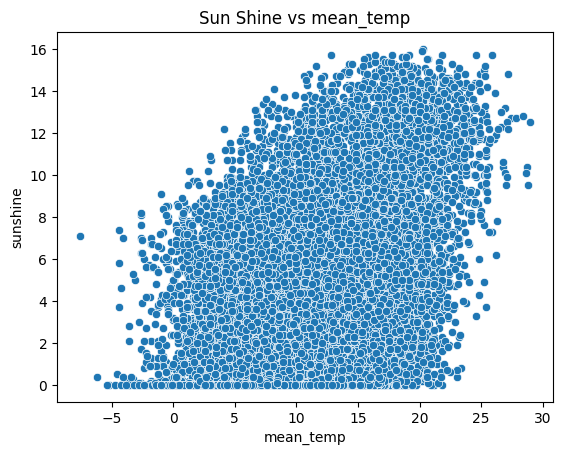

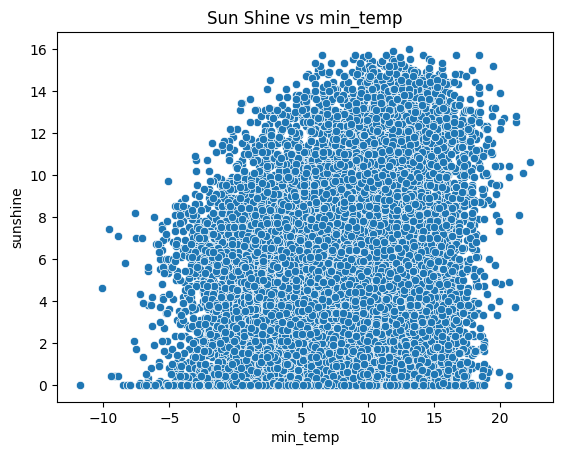

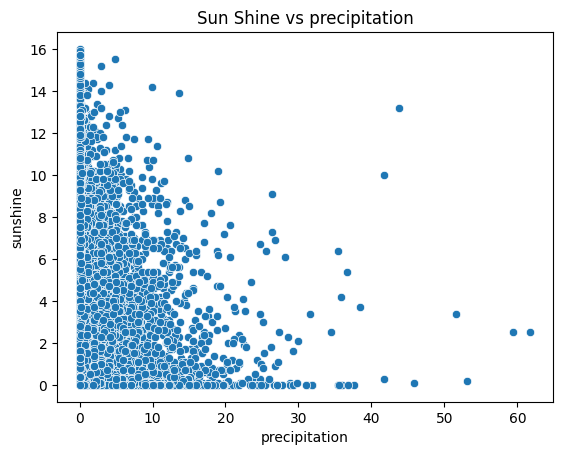

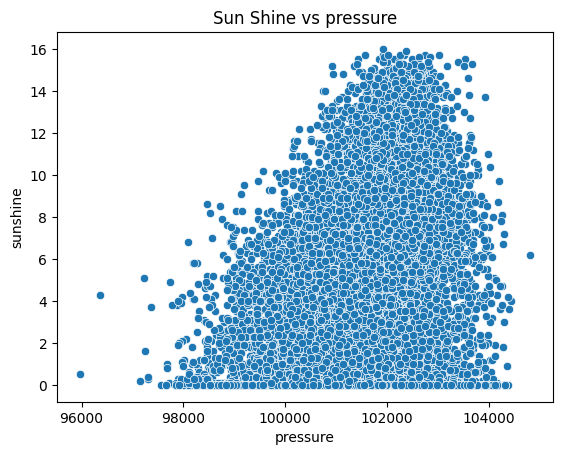

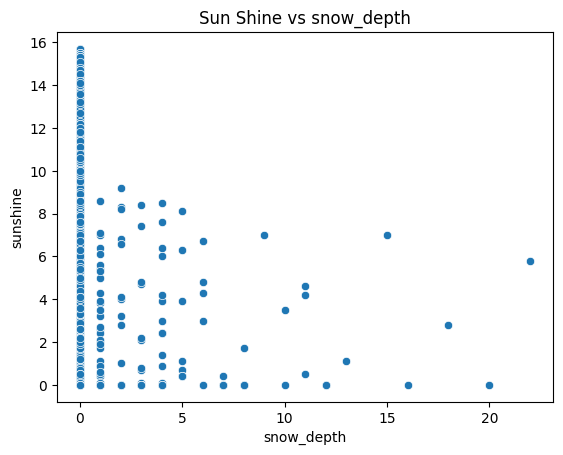

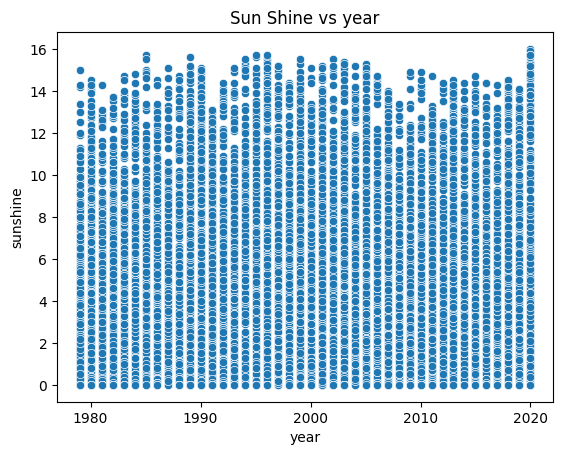

In [36]:
# 1. Plotting a heatmap to visualize correlations
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

plt.bar(data.columns, data.isnull().sum())
plt.xticks(rotation=45)
plt.title('Missing Values in Data')
plt.show()



tot_snow_data = data['snow_depth'].count()
snow_data = data['snow_depth'].map(lambda x: 1 if x > 0 else 0).sum()
nosnow_data = data['snow_depth'].map(lambda x: 1 if x == 0 else 0).sum()
bars = plt.bar(["Total Snow Data", "No Snow", "Snow"], [tot_snow_data, nosnow_data, snow_data])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
plt.title('Snow Depth Distribution')
plt.show()

# # Precipitation data analysis
# tot_precip_data = data['precipitation'].count()
# precip_data = data['precipitation'].map(lambda x: 1 if x > 0 else 0).sum()
# noprecip_data = data['precipitation'].map(lambda x: 1 if x == 0 else 0).sum()
# bars = plt.bar(["Total Precipitation Data", "No Precipitation", "Precipitation"], [tot_precip_data, noprecip_data, precip_data])
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
# plt.title('Precipitation Distribution')
# plt.show()

# # 2. Pairplot to visualize relationships between variables
sns.pairplot(data)
plt.show()

# Histogram to visualize the distribution of sunshine
plt.hist(data['sunshine'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Sunshine')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Frequency')
plt.show()

# Boxplot to visualize the spread and outliers in sunshine data
sns.boxplot(x=data['sunshine'])
plt.title('Boxplot of Sunshine')
plt.xlabel('Sunshine (hours)')
plt.show()

# Line plot to visualize sunshine over time
plt.plot(data['date'], data['sunshine'])
plt.title('Sunshine Over Time')
plt.xlabel('Date')
plt.ylabel('Sunshine (hours)')
plt.xticks(rotation=45)
plt.show()

# Violin plot to visualize the distribution of sunshine
sns.violinplot(x=data['sunshine'])
plt.title('Violin Plot of Sunshine')
plt.xlabel('Sunshine (hours)')
plt.show()

# 3. Plotting snow depth vs other variables for a deeper look
for col in data.columns:
    if col != 'sunshine':
        sns.scatterplot(x=col, y='sunshine', data=data)
        plt.title(f'Sun Shine vs {col}')
        plt.show()

        


Mean Squared Error: 0.13901751798561152
R2 Score: 0.1575706647409042
Random Forest - Accuracy: 0.9615107913669064
Confusion Matrix:
[[2601  155]
 [   2   22]]


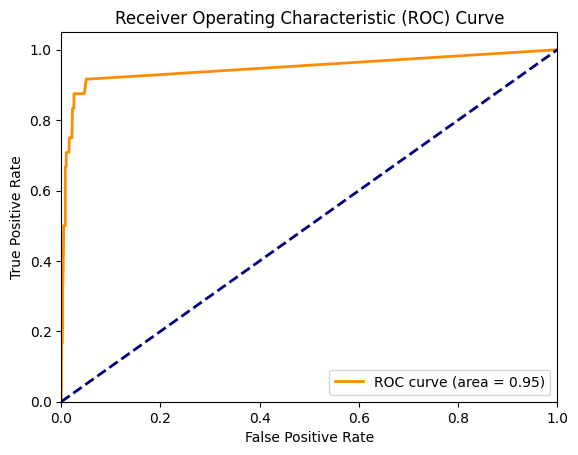

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2756
           1       0.12      0.92      0.22        24

    accuracy                           0.94      2780
   macro avg       0.56      0.93      0.59      2780
weighted avg       0.99      0.94      0.96      2780



In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc

X = data.drop(columns=['date', 'snow_depth', 'cloud_cover'])  # Drop date and target variable snow_depth

y = data['snow_depth'].dropna()  # Remove NaN values from target variable

# Offset the training data by 1 day to predict one day into the future
X = X.shift(2)
# Align X with y after dropping NaN values
X = X.loc[y.index]

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# Calculate accuracy for the Random Forest model with continuous values
accuracy_rf = np.mean(np.isclose(y_test, y_pred, atol=0.1))
print(f'Random Forest - Accuracy: {accuracy_rf}')

# Since this is a regression problem, we need to convert the continuous predictions to discrete classes
# For simplicity, let's assume snow_depth > 0 is class 1 (snow) and snow_depth == 0 is class 0 (no snow)
y_test_class = (y_test > 0).astype(int)
y_pred_class = (y_pred > 0).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_class, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Printing classification report
print(classification_report(y_test_class, y_pred_class))

Decision Tree - Accuracy: 0.9830935251798562
Linear Regression - Accuracy: 0.6733812949640288
Ridge Regression - Accuracy: 0.6733812949640288
Confusion Matrix - Decision Tree:
[[2732   24]
 [  16    8]]
Confusion Matrix - Linear Regression:
[[ 892 1864]
 [   0   24]]
Confusion Matrix - Ridge Regression:
[[ 892 1864]
 [   0   24]]


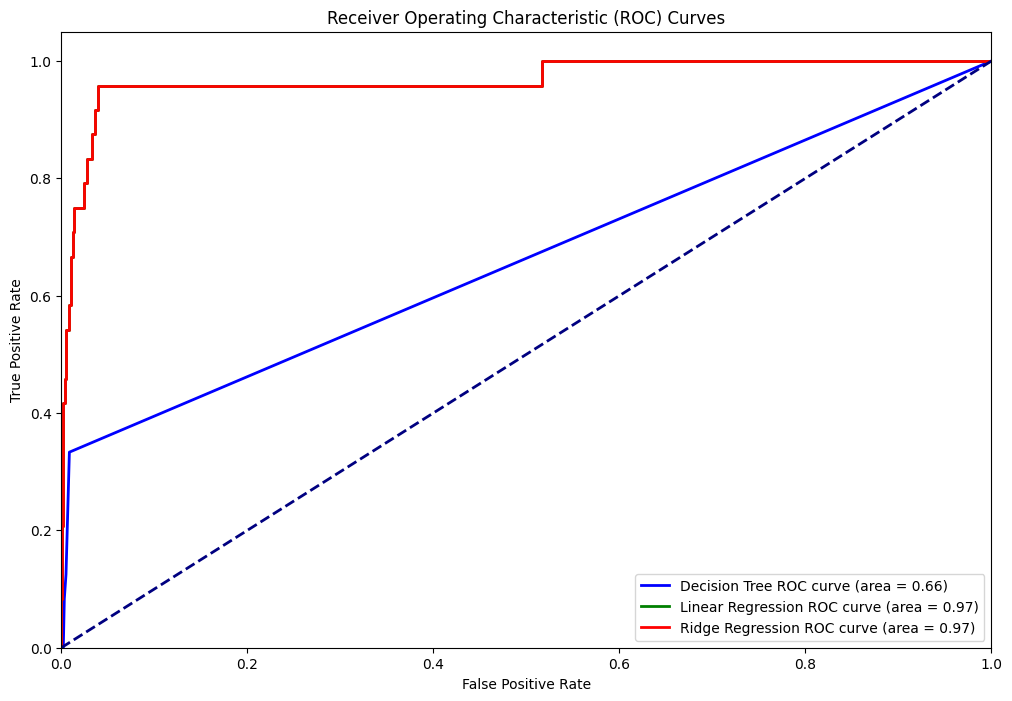

Decision Tree - MSE: 0.3273381294964029, R2: -0.9836294506793879
Linear Regression - MSE: 0.16201874459319407, R2: 0.018186015079879825
Ridge Regression - MSE: 0.16201871240753757, R2: 0.018186210121063362

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2756
           1       0.25      0.33      0.29        24

    accuracy                           0.99      2780
   macro avg       0.62      0.66      0.64      2780
weighted avg       0.99      0.99      0.99      2780


Classification Report - Linear Regression:
              precision    recall  f1-score   support

           0       1.00      0.32      0.49      2756
           1       0.01      1.00      0.03        24

    accuracy                           0.33      2780
   macro avg       0.51      0.66      0.26      2780
weighted avg       0.99      0.33      0.49      2780


Classification Report - Ridge Regression:
             

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.impute import SimpleImputer

# Assuming X_train, X_test, y_train, y_test are already defined from the previous split

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_imputed, y_train)
y_pred_dt = dt.predict(X_test_imputed)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_imputed, y_train)
y_pred_lr = lr.predict(X_test_imputed)

# Ridge Regression
ridge = Ridge(random_state=42)
ridge.fit(X_train_imputed, y_train)
y_pred_ridge = ridge.predict(X_test_imputed)

# Evaluating each model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Calculate accuracy for each model with continuous values
accuracy_dt = np.mean(np.isclose(y_test, y_pred_dt, atol=0.1))
accuracy_lr = np.mean(np.isclose(y_test, y_pred_lr, atol=0.1))
accuracy_ridge = np.mean(np.isclose(y_test, y_pred_ridge, atol=0.1))

print(f'Decision Tree - Accuracy: {accuracy_dt}')
print(f'Linear Regression - Accuracy: {accuracy_lr}')
print(f'Ridge Regression - Accuracy: {accuracy_ridge}')

# Convert continuous predictions to binary classes (snow > 0, no snow == 0)
y_test_class = (y_test > 0).astype(int)
y_pred_dt_class = (y_pred_dt > 0).astype(int)
y_pred_lr_class = (y_pred_lr > 0).astype(int)
y_pred_ridge_class = (y_pred_ridge > 0).astype(int)

# Confusion Matrices
conf_matrix_dt = confusion_matrix(y_test_class, y_pred_dt_class)
conf_matrix_lr = confusion_matrix(y_test_class, y_pred_lr_class)
conf_matrix_ridge = confusion_matrix(y_test_class, y_pred_ridge_class)

print("Confusion Matrix - Decision Tree:")
print(conf_matrix_dt)

print("Confusion Matrix - Linear Regression:")
print(conf_matrix_lr)

print("Confusion Matrix - Ridge Regression:")
print(conf_matrix_ridge)

# ROC Curves
fpr_dt, tpr_dt, _ = roc_curve(y_test_class, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_lr, tpr_lr, _ = roc_curve(y_test_class, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_ridge, tpr_ridge, _ = roc_curve(y_test_class, y_pred_ridge)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)

plt.figure(figsize=(12, 8))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Decision Tree ROC curve (area = {roc_auc_dt:.2f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Linear Regression ROC curve (area = {roc_auc_lr:.2f})')
plt.plot(fpr_ridge, tpr_ridge, color='red', lw=2, label=f'Ridge Regression ROC curve (area = {roc_auc_ridge:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Classification reports for each model
classification_report_dt = classification_report(y_test_class, y_pred_dt_class)
classification_report_lr = classification_report(y_test_class, y_pred_lr_class)
classification_report_ridge = classification_report(y_test_class, y_pred_ridge_class)

# Print results
print(f'Decision Tree - MSE: {mse_dt}, R2: {r2_dt}')
print(f'Linear Regression - MSE: {mse_lr}, R2: {r2_lr}')
print(f'Ridge Regression - MSE: {mse_ridge}, R2: {r2_ridge}')

print("\nClassification Report - Decision Tree:")
print(classification_report_dt)

print("\nClassification Report - Linear Regression:")
print(classification_report_lr)

print("\nClassification Report - Ridge Regression:")
print(classification_report_ridge)
